# Displaced Diffusion Model Claibration

### SPX Calibration for each time maturities

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import array

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import least_squares

import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Given,On 1-Dec-2020, the S&P500 (SPX) index value was 3662.45, while the SPDR S&P500 Exchange Traded Fund (SPY) stock price was 366.02
S_spx = 3662.45
S_spy = 366.02

In [3]:
def DisplacedDiffusion_Call(S, K, r, sigma, T, B):
    d1 = (np.log((S/B)/(K+(1-B)*S/B))+0.5*(B**2)*(sigma**2)*T)/(B*sigma*np.sqrt(T))
    d2 = d1 - B*sigma*np.sqrt(T)
    asset_or_nothing_call = S/B*(np.exp(-r*T))*norm.cdf(d1)
    cash_or_nothing_call = (np.exp(-r*T))*norm.cdf(d2)
    call = asset_or_nothing_call - (K+(1-B)*S/B)*cash_or_nothing_call
    return call

def DisplacedDiffusion_Put(S, K, r, sigma, T, B):
    d1 = (np.log((S/B)/(K+(1-B)*S/B))+0.5*(B**2)*(sigma**2)*T)/(B*sigma*np.sqrt(T))
    d2 = d1 - B*sigma*np.sqrt(T)
    asset_or_nothing_put = S/B*(np.exp(-r*T))*norm.cdf(-d1)
    cash_or_nothing_put = (np.exp(-r*T))*norm.cdf(-d2)
    put = -asset_or_nothing_put + (K+(1-B)*S/B)*cash_or_nothing_put
    return put

In [4]:
def BlackScholesVanillaCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesVanillaPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [5]:
#Define the Black Scholes implied vol calculator function 
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesVanillaCall(S, K, r, x, T),
                                a = 1e-12,b = 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesVanillaPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [6]:
df = pd.read_csv('SPX_options.csv')
rates_df = pd.read_csv('zero_rates_20201201.csv')

In [7]:
df["date"] = pd.to_datetime(df['date'], format='%Y%m%d')
df["exdate"] = pd.to_datetime(df['exdate'], format='%Y%m%d')
df['T'] = (df["exdate"] - df["date"]).dt.days/365

df['r'] = np.interp((df["exdate"] - df["date"]).dt.days, rates_df["days"], rates_df["rate"])/100
df['Price'] = (df['best_bid'] + df['best_offer'])/2
df['Strike'] = (df['strike_price'])/1000
df['Payoff'] = np.where(df['cp_flag']=="C","Call","Put")
df['F'] = S_spx*np.exp(df['r']*df['T'])

In [8]:
#Find and Calculate Market Implied Vols for ATM options
df_atm = df[df['Strike'] == 3660].reset_index(drop=True)
df_atm["BS_ImpliedVol"] = False
for i in range(0,len(df_atm)):
    df_atm["BS_ImpliedVol"][i] = impliedVolatility(S_spx, df_atm['Strike'][i], df_atm['r'][i], df_atm['Price'][i], df_atm['T'][i], df_atm['Payoff'][i])

In [9]:
#Calculate ATM Implied Vols for 3 expiries
sigma_atm = [(df_atm["BS_ImpliedVol"][0] + df_atm["BS_ImpliedVol"][1])/2 , (df_atm["BS_ImpliedVol"][2] + df_atm["BS_ImpliedVol"][3])/2 , (df_atm["BS_ImpliedVol"][4] + df_atm["BS_ImpliedVol"][5])/2]
sigma_atm

[0.1750985704585497, 0.18537188428716733, 0.1909732726819407]

In [10]:
#Remove ITM Call and Puts from df
df["Keep"] = np.where((df['Strike']>df['F']) & (df['Payoff'] == "Call"),True, False)
df["Keep"] = np.where((df['Strike']<df['F']) & (df['Payoff'] == "Put"),True, df["Keep"])
df = df[df["Keep"]==True].reset_index(drop = True)

In [11]:
#Calculate Market Implied Vols
df["BS_ImpliedVol"] = False

for i in range(0,len(df)):
    df["BS_ImpliedVol"][i] = impliedVolatility(S_spx, df['Strike'][i], df['r'][i], df['Price'][i], df['T'][i], df['Payoff'][i])

In [12]:
df_raw = df.copy()

In [13]:
#Define the Displaced Diffusion implied vol calculator function 
def DisplacedimpliedVolatility(S, K, r, T, B, payoff):
    try:
        if (payoff.lower() == 'call'):
            price = DisplacedDiffusion_Call(S, K, r, sigma, T, B)
            impliedVol = brentq(lambda x: price -
                                BlackScholesVanillaCall(S, K, r, x, T),
                                a = 1e-12,b = 10.0)
        elif (payoff.lower() == 'put'):
            price = DisplacedDiffusion_Put(S, K, r, sigma, T, B)
            impliedVol = brentq(lambda x: price -
                                BlackScholesVanillaPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [14]:
def Displacedcalibration(x, S, strikes,r, vols, T, payoff):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - DisplacedimpliedVolatility(S, strikes[i], r, T, x[0], payoff[i]))**2

    return err

Expiry of : 12/18/2020
Calibrated Displaced Diffusion model parameters:beta = -21.0, sigma = 0.175


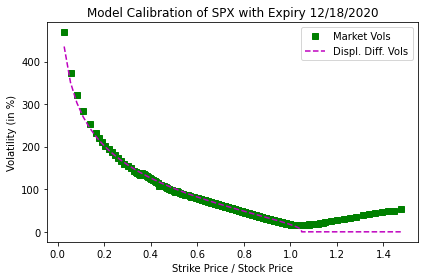

Expiry of : 01/15/2021
Calibrated Displaced Diffusion model parameters:beta = -9.7, sigma = 0.185


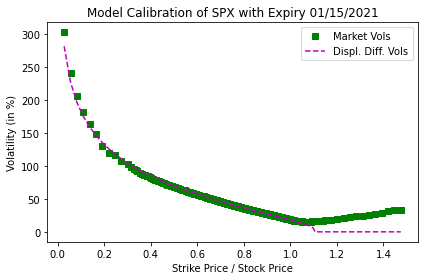

Expiry of : 02/19/2021
Calibrated Displaced Diffusion model parameters:beta = -5.9, sigma = 0.191


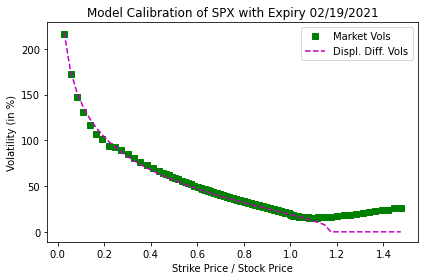

In [15]:
for i in range(0,len(df_raw["exdate"].unique())):    
    expdatetoprint = df_raw["exdate"].unique()[i]
    expdatetoprint = pd.to_datetime(expdatetoprint)
    print("Expiry of : " + expdatetoprint.strftime('%m/%d/%Y'))
    
    df = df_raw[df_raw["exdate"] == df_raw["exdate"].unique()[i]].reset_index(drop= True)
    r = df['r'].unique()[0]
    T = df['T'].unique()[0]
    sigma = sigma_atm[i]
    
    initialGuess = [0.8]
    
    res = least_squares(lambda x: Displacedcalibration(x, S_spx, df['Strike'], r, df['BS_ImpliedVol'], T, df['Payoff']), 
                        initialGuess)
    beta = res.x[0]

    print('Calibrated Displaced Diffusion model parameters:beta = %.1f, sigma = %.3f' % (beta, sigma))
    
    df['DispDiffVol'] = False
    for i in range(0,len(df)):
    #df['DispDiffVol'][i] = SABR(F, df['Strike'][i], T, alpha, beta, rho, nu)
        df['DispDiffVol'][i] = DisplacedimpliedVolatility(S_spx, df['Strike'][i], r, T, beta, df['Payoff'][i])
    df.sort_values(by=['Strike'], inplace = True)
    
    plt.figure(tight_layout=True)
    plt.plot(df['Strike']/S_spx, df['BS_ImpliedVol']*100, 'gs', label='Market Vols')
    plt.plot(df['Strike']/S_spx, df['DispDiffVol']*100, 'm--', label='Displ. Diff. Vols')
    plt.xlabel("Strike Price / Stock Price")
    plt.ylabel("Volatility (in %)")
    plt.title("Model Calibration of SPX with Expiry " + expdatetoprint.strftime('%m/%d/%Y'))
    plt.legend()
    plt.show()

### SPY Calibration for each time maturities

In [16]:
def american_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    prices = array.array('d', (0 for i in range(0, steps+1)))

    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]
            call_values[i] = max(call_values[i], 1.0*(prices[i]-K))

    return call_values[0]


def american_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
            put_values[i] = max(put_values[i], (K-prices[i]))
    return put_values[0]

def impliedVolatility_americanoptions(S, K, r, price, T, payoff, steps):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                american_call(S, K, r, x, T, steps),
                                a = 1e-12,b = 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                american_put(S, K, r, x, T, steps),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [23]:
df = pd.read_csv('SPY_options.csv')
rates_df = pd.read_csv('zero_rates_20201201.csv')

In [24]:
df["date"] = pd.to_datetime(df['date'], format='%Y%m%d')
df["exdate"] = pd.to_datetime(df['exdate'], format='%Y%m%d')
df['T'] = (df["exdate"] - df["date"]).dt.days/365

df['r'] = np.interp((df["exdate"] - df["date"]).dt.days, rates_df["days"], rates_df["rate"])/100
df['Price'] = (df['best_bid'] + df['best_offer'])/2
df['Strike'] = (df['strike_price'])/1000
df['Payoff'] = np.where(df['cp_flag']=="C","Call","Put")
df['F'] = S_spy*np.exp(df['r']*df['T'])

In [25]:
#Find and Calculate Market Implied Vols for ATM options
df_atm = df[df['Strike'] == 366].reset_index(drop=True)
df_atm["BS_ImpliedVol"] = False
for i in range(0,len(df_atm)):
    df_atm["BS_ImpliedVol"][i] = impliedVolatility_americanoptions(S_spy, df_atm['Strike'][i], df_atm['r'][i], df_atm['Price'][i], df_atm['T'][i], df_atm['Payoff'][i], steps = 50)

In [26]:
#Calculate ATM Implied Vols for 3 expiries
sigma_atm = [(df_atm["BS_ImpliedVol"][0] + df_atm["BS_ImpliedVol"][1])/2 , (df_atm["BS_ImpliedVol"][2] + df_atm["BS_ImpliedVol"][3])/2 , (df_atm["BS_ImpliedVol"][4] + df_atm["BS_ImpliedVol"][5])/2]
sigma_atm

[0.10124588433780789, 0.1856646273529258, 0.10074197824658551]

In [27]:
#Remove ITM Call and Puts from df
df["Keep"] = np.where((df['Strike']>df['F']) & (df['Payoff'] == "Call"),True, False)
df["Keep"] = np.where((df['Strike']<df['F']) & (df['Payoff'] == "Put"),True, df["Keep"])
df = df[df["Keep"]==True].reset_index(drop = True)

In [29]:
#Calculate Market Implied Vols
df["BS_ImpliedVol"] = False

for i in range(0,len(df)):
    df["BS_ImpliedVol"][i] = impliedVolatility_americanoptions(S_spy, df['Strike'][i], df['r'][i], df['Price'][i], df['T'][i], df['Payoff'][i], steps = 50)

In [30]:
df_raw = df.copy()

In [31]:
#Define the Displaced Diffusion implied vol calculator function 
def DisplacedimpliedVolatility_american(S, K, r, T, B, payoff):
    try:
        if (payoff.lower() == 'call'):
            price = DisplacedDiffusion_Call(S, K, r, sigma, T, B)
            impliedVol = brentq(lambda x: price -
                                american_call(S, K, r, x, T, steps = 50),
                                a = 1e-12,b = 10.0)
        elif (payoff.lower() == 'put'):
            price = DisplacedDiffusion_Put(S, K, r, sigma, T, B)
            impliedVol = brentq(lambda x: price -
                                american_put(S, K, r, x, T, steps = 50),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [38]:
def Displacedcalibration_american(x, S, strikes,r, vols, T, payoff):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - DisplacedimpliedVolatility_american(S, strikes[i], r, T, x[0], payoff[i]))**2

    return err

Expiry of : 12/18/2020
Calibrated Displaced Diffusion model parameters:beta = -2.0, sigma = 0.101


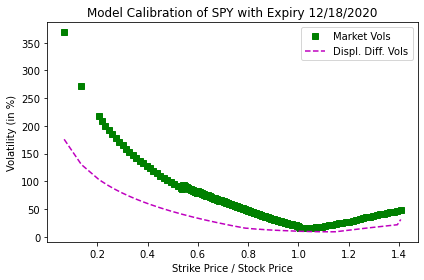

Expiry of : 01/15/2021
Calibrated Displaced Diffusion model parameters:beta = -9.6, sigma = 0.186


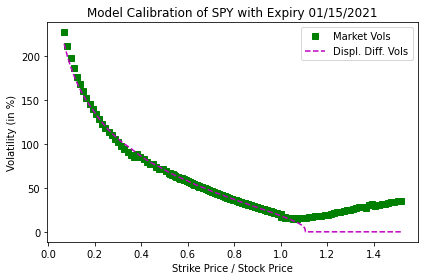

Expiry of : 02/19/2021
Calibrated Displaced Diffusion model parameters:beta = -25.6, sigma = 0.101


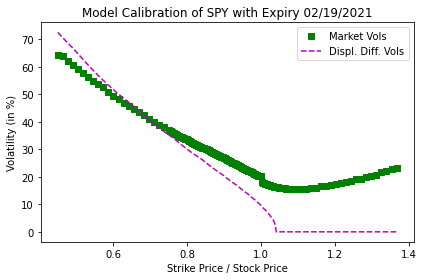

In [39]:
for i in range(0,len(df_raw["exdate"].unique())):    
    expdatetoprint = df_raw["exdate"].unique()[i]
    expdatetoprint = pd.to_datetime(expdatetoprint)
    print("Expiry of : " + expdatetoprint.strftime('%m/%d/%Y'))
    
    df = df_raw[df_raw["exdate"] == df_raw["exdate"].unique()[i]].reset_index(drop= True)
    r = df['r'].unique()[0]
    T = df['T'].unique()[0]
    sigma = sigma_atm[i]
    
    initialGuess = [0.8]
    
    res = least_squares(lambda x: Displacedcalibration_american(x, S_spy, df['Strike'], r, df['BS_ImpliedVol'], T, df['Payoff']), 
                        initialGuess)
    beta = res.x[0]

    print('Calibrated Displaced Diffusion model parameters:beta = %.1f, sigma = %.3f' % (beta, sigma))
    
    df['DispDiffVol'] = False
    for i in range(0,len(df)):
    #df['DispDiffVol'][i] = SABR(F, df['Strike'][i], T, alpha, beta, rho, nu)
        df['DispDiffVol'][i] = DisplacedimpliedVolatility_american(S_spy, df['Strike'][i], r, T, beta, df['Payoff'][i])
    df.sort_values(by=['Strike'], inplace = True)
    
    plt.figure(tight_layout=True)
    plt.plot(df['Strike']/S_spy, df['BS_ImpliedVol']*100, 'gs', label='Market Vols')
    plt.plot(df['Strike']/S_spy, df['DispDiffVol']*100, 'm--', label='Displ. Diff. Vols')
    plt.xlabel("Strike Price / Stock Price")
    plt.ylabel("Volatility (in %)")
    plt.title("Model Calibration of SPY with Expiry " + expdatetoprint.strftime('%m/%d/%Y'))
    plt.legend()
    plt.show()

# SABR Model Calibration

### SPX Calibration for each time maturities

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import array

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import least_squares

import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Given,On 1-Dec-2020, the S&P500 (SPX) index value was 3662.45, while the SPDR S&P500 Exchange Traded Fund (SPY) stock price was 366.02
S_spx = 3662.45
S_spy = 366.02

In [3]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

In [4]:
def BlackScholesVanillaCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesVanillaPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [5]:
#Define the Black Scholes implied vol calculator function 
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesVanillaCall(S, K, r, x, T),
                                a = 1e-12,b = 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesVanillaPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [21]:
def DisplacedDiffusion(S, K, r, sigma, T, B, payoff):
    
        d1 = (np.log((S/B)/(K+(1-B)*S/B))+0.5*(B**2)*(sigma**2)*T)/(B*sigma*np.sqrt(T))
        d2 = d1 - B*sigma*np.sqrt(T)
    
        if payoff == 'call':
            asset_or_nothing = S/B*(np.exp(-r*T))*norm.cdf(d1)
            cash_or_nothing = (np.exp(-r*T))*norm.cdf(d2)
            Dis = asset_or_nothing - (K+(1-B)*S/B)*cash_or_nothing
            return Dis
    
        elif payoff == 'put':
            asset_or_nothing = S/B*(np.exp(-r*T))*norm.cdf(-d1)
            cash_or_nothing = (np.exp(-r*T))*norm.cdf(-d2)
            Dis = -asset_or_nothing + (K+(1-B)*S/B)*cash_or_nothing
            return Dis

In [6]:
df = pd.read_csv('SPX_options.csv')
rates_df = pd.read_csv('zero_rates_20201201.csv')

In [7]:
df["date"] = pd.to_datetime(df['date'], format='%Y%m%d')
df["exdate"] = pd.to_datetime(df['exdate'], format='%Y%m%d')
df['T'] = (df["exdate"] - df["date"]).dt.days/365

df['r'] = np.interp((df["exdate"] - df["date"]).dt.days, rates_df["days"], rates_df["rate"])
df['Price'] = (df['best_bid'] + df['best_offer'])/2
df['Strike'] = (df['strike_price'])/1000
df['Payoff'] = np.where(df['cp_flag']=="C","Call","Put")
df['F'] = S_spx*np.exp(df['r']*df['T'])

In [8]:
#Remove ITM Call and Puts
df["Keep"] = np.where((df['Strike']>df['F']) & (df['Payoff'] == "Call"),True, False)
df["Keep"] = np.where((df['Strike']<df['F']) & (df['Payoff'] == "Put"),True, df["Keep"])
df = df[df["Keep"]==True].reset_index(drop = True)

In [9]:
#Calculate Market Implied Vols
df["BS_ImpliedVol"] = False

for i in range(0,len(df)):
    df["BS_ImpliedVol"][i] = impliedVolatility(S_spx, df['Strike'][i], df['r'][i], df['Price'][i], df['T'][i], df['Payoff'][i])

In [10]:
df_raw = df.copy()

In [11]:
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

Expiry of : 12/18/2020
Calibrated SABR model parameters: alpha = 1.240, beta = 0.7, rho = -0.360, nu = 5.419


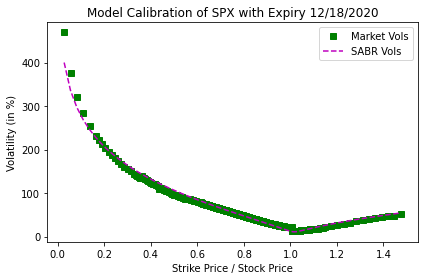

Expiry of : 01/15/2021
Calibrated SABR model parameters: alpha = 1.999, beta = 0.7, rho = -0.633, nu = 2.664


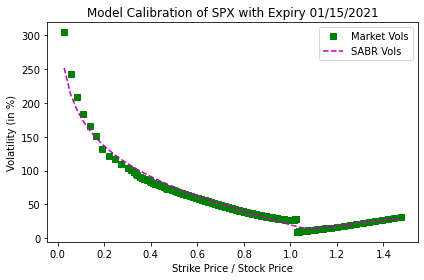

Expiry of : 02/19/2021
Calibrated SABR model parameters: alpha = 2.553, beta = 0.7, rho = -0.818, nu = 1.687


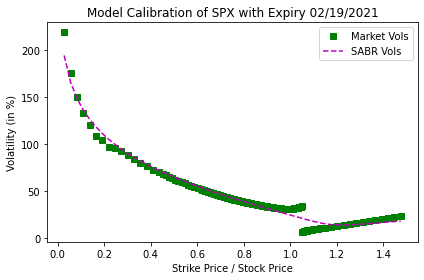

In [12]:
for i in range(0,len(df_raw["exdate"].unique())):    
    expdatetoprint = df_raw["exdate"].unique()[i]
    expdatetoprint = pd.to_datetime(expdatetoprint)
    print("Expiry of : " + expdatetoprint.strftime('%m/%d/%Y'))
    
    df = df_raw[df_raw["exdate"] == df_raw["exdate"].unique()[i]].reset_index(drop= True)
    F = df['F'].unique()[0]
    T = df['T'].unique()[0]

    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['Strike'],
                                                  df['BS_ImpliedVol'],
                                                  F,
                                                  T),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]

    print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

    df['SABRVol'] = False
    for i in range(0,len(df)):
        df['SABRVol'][i] = SABR(F, df['Strike'][i], T, alpha, beta, rho, nu)
    df.sort_values(by=['Strike'], inplace = True)
    
    plt.figure(tight_layout=True)
    plt.plot(df['Strike']/S_spx, df['BS_ImpliedVol']*100, 'gs', label='Market Vols')
    plt.plot(df['Strike']/S_spx, df['SABRVol']*100, 'm--', label='SABR Vols')
    plt.xlabel("Strike Price / Stock Price")
    plt.ylabel("Volatility (in %)")
    plt.title("Model Calibration of SPX with Expiry " + expdatetoprint.strftime('%m/%d/%Y'))
    plt.legend()
    plt.show()

### SPY Calibration for each time maturities

In [13]:
df = pd.read_csv('SPY_options.csv')

In [14]:
df["date"] = pd.to_datetime(df['date'], format='%Y%m%d')
df["exdate"] = pd.to_datetime(df['exdate'], format='%Y%m%d')
df['T'] = (df["exdate"] - df["date"]).dt.days/365

df['r'] = np.interp((df["exdate"] - df["date"]).dt.days, rates_df["days"], rates_df["rate"])
df['Price'] = (df['best_bid'] + df['best_offer'])/2
df['Strike'] = (df['strike_price'])/1000
df['Payoff'] = np.where(df['cp_flag']=="C","Call","Put")
df['F'] = S_spy*np.exp(df['r']*df['T'])

In [15]:
#Remove ITM Call and Puts
df["Keep"] = np.where((df['Strike']>df['F']) & (df['Payoff'] == "Call"),True, False)
df["Keep"] = np.where((df['Strike']<df['F']) & (df['Payoff'] == "Put"),True, df["Keep"])
df = df[df["Keep"]==True].reset_index(drop = True)

In [16]:
def american_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    prices = array.array('d', (0 for i in range(0, steps+1)))

    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]
            call_values[i] = max(call_values[i], 1.0*(prices[i]-K))

    return call_values[0]


def american_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
            put_values[i] = max(put_values[i], (K-prices[i]))
    return put_values[0]

def impliedVolatility_americanoptions(S, K, r, price, T, payoff, steps):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                american_call(S, K, r, x, T, steps),
                                a = 1e-12,b = 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                american_put(S, K, r, x, T, steps),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [17]:
#Calculate Market Implied Vols
df["BS_ImpliedVol"] = False

for i in range(0,len(df)):
    df["BS_ImpliedVol"][i] = impliedVolatility_americanoptions(S_spy, df['Strike'][i], 
                                                               df['r'][i], df['Price'][i], df['T'][i], df['Payoff'][i],
                                                               steps = 50)

In [18]:
df_raw = df.copy()

Expiry of : 12/18/2020
Calibrated SABR model parameters: alpha = 0.640, beta = 0.7, rho = -0.435, nu = 5.414


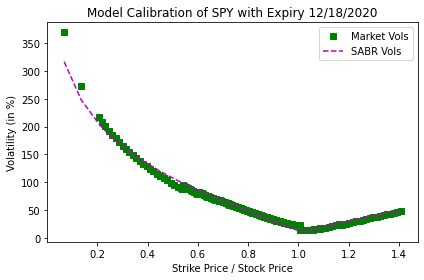

Expiry of : 01/15/2021
Calibrated SABR model parameters: alpha = 0.928, beta = 0.7, rho = -0.568, nu = 2.768


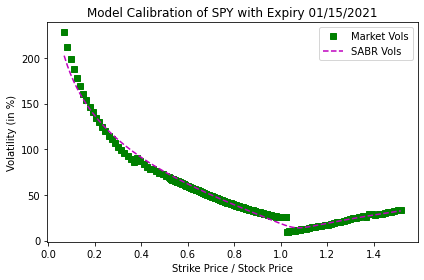

Expiry of : 02/19/2021
Calibrated SABR model parameters: alpha = 1.234, beta = 0.7, rho = -0.799, nu = 1.718


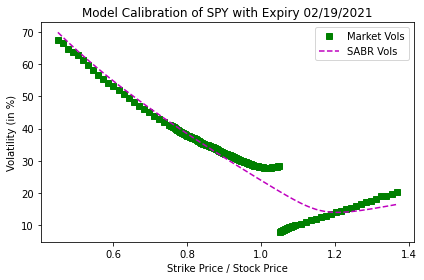

In [19]:
for i in range(0,len(df_raw["exdate"].unique())):    
    expdatetoprint = df_raw["exdate"].unique()[i]
    expdatetoprint = pd.to_datetime(expdatetoprint)
    print("Expiry of : " + expdatetoprint.strftime('%m/%d/%Y'))
    
    df = df_raw[df_raw["exdate"] == df_raw["exdate"].unique()[i]].reset_index(drop= True)
    F = df['F'].unique()[0]
    T = df['T'].unique()[0]
    
    beta = 0.7

    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['Strike'],
                                                  df['BS_ImpliedVol'],
                                                  F,
                                                  T),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]

    print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

    df['SABRVol'] = False
    for i in range(0,len(df)):
        df['SABRVol'][i] = SABR(F, df['Strike'][i], T, alpha, beta, rho, nu)
    df.sort_values(by=['Strike'], inplace = True)
    
    plt.figure(tight_layout=True)
    plt.plot(df['Strike']/S_spy, df['BS_ImpliedVol']*100, 'gs', label='Market Vols')
    plt.plot(df['Strike']/S_spy, df['SABRVol']*100, 'm--', label='SABR Vols')
    plt.xlabel("Strike Price / Stock Price")
    plt.ylabel("Volatility (in %)")
    plt.title("Model Calibration of SPY with Expiry " + expdatetoprint.strftime('%m/%d/%Y'))
    plt.legend()
    plt.show()